# Support Vector Machines (SVM) - Guide using the Titanic Dataset

---

## 1. What is SVM?

A Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and sometimes regression.

For classification, SVM tries to separate different classes optimally (e.g., survivors vs. non-survivors) using a decision boundary called a **hyperplane**. The goal is to maximize the margin, which is the distance between the hyperplane and the closest points from each class.

Think of it like drawing a line in the sand that separates two groups of seashells, but you want the line to be as far away as possible from the nearest shells on either side.

---

### 1.1. Intuition

SVM aims to:
- Separate classes using a **hyperplane**
- **Maximize the margin** between the nearest data points of each class
- Use only the **support vectors** (the closest points to the hyperplane) matter to define the decision boundary

A larger margin usually means better performance on unseen data. The hyperplane is chosen to maximize this margin, balancing accuracy and robustness.

---

### 1.2.  Mathematics of Linear SVM

For binary classification with labels $y_i \in \{-1, 1\}$ and data points $x_i \in \mathbb{R}^n$, the primal form of the optimization problem is:

$$\min_{w, b} \ \frac{1}{2} \|w\|^2$$

subject to:

$$y_i (w \cdot x_i + b) \geq 1 \quad \text{for all } i$$

Where:

- $w$ is the normal vector to the hyperplane
- $b$ is the bias term (offset of the hyperplane)
- The margin width is $\frac{2}{\|w\|}$

If the classes are not perfectly (linearly) separable, we allow some mistakes using **slack variables** $\xi_i$ and a **regularization parameter** $C$:

$$\min_{w, b, \xi} \ \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i$$

- $C$ controls how much you penalize misclassifications: a small $C$ allows more mistakes but can improve generalization.

---

### 1.3. Handling Nonlinear Data: The Kernel Trick

Sometimes, data cannot be separated by a straight line (nonlinear boundaries). SVM solves this using **kernels**, which transform (project) the data into a higher-dimensional space where separation is possible.


The kernel function $K(x_i, x_j) = \phi(x_i)^T \phi(x_j)$ computes inner products in that space **without explicitly transforming the data** (saves computation).

Common kernels:

| Kernel | Formula | Use Case |
|--------|---------|---------|
| Linear | $K(x, x') = x^T x'$ | When data is linearly separable |
| Polynomial | $K(x, x') = (x^T x' + 1)^d$ | Nonlinear patterns with polynomial shape |
| RBF (Gaussian) | $K(x, x') = \exp(-\gamma \|x - x'\|^2)$ | Complex nonlinear boundaries |

---

### 1.4. Key Parameters in SVM

| Parameter | Description |
|----------|-------------|
| `C` | Regularization parameter: trade-off between margin width and misclassification |
| `kernel` | Defines the kernel type (e.g., `'linear'`, `'rbf'`) |
| `gamma` | Controls the influence (kernel complexity) in RBF and polynomial kernels |

**Tip:** SVMs are sensitive to feature scaling. Always standardize your features before training.

---

## 2. Real-World Example: Predicting Titanic Survival with SVM

---

In [11]:
## 1. Load and Explore Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, roc_curve

# Load Titanic dataset
df = sns.load_dataset('titanic')

df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
df.dropna(inplace = True)

In [2]:
## 2. Preprocess the Data
# Encode categorical features
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Features and target
X = df.drop('survived', axis=1)
y = df['survived']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

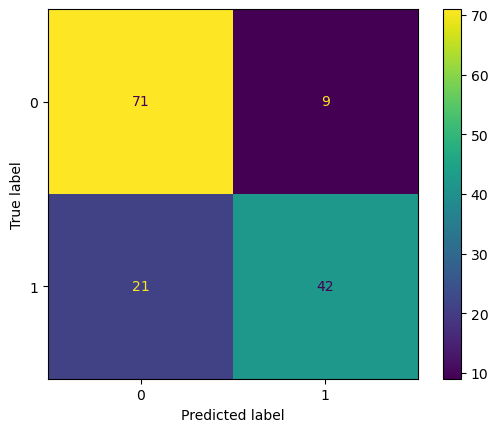

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        80
           1       0.82      0.67      0.74        63

    accuracy                           0.79       143
   macro avg       0.80      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143

ROC-AUC: 0.8201


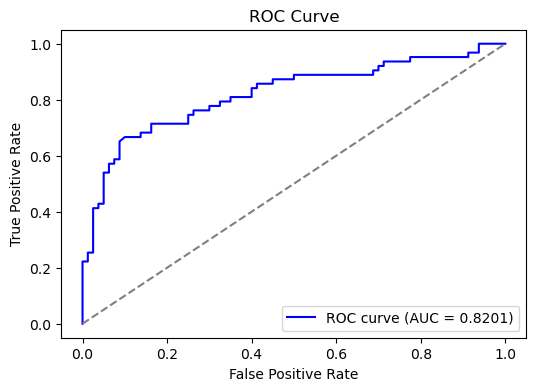

In [22]:
## 3. Train and Evaluate SVM Model
model = SVC(kernel = 'rbf', C = 10, gamma = 'scale', probability = True)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Predictions
y_pred = model.predict(X_test_scaled)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.show()

# ROC-AUC
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class
roc_auc = roc_auc_score(y_test, y_proba)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc, 4))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
## 4. Hyperparameter Tuning with Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv = 5)
grid.fit(X_train_scaled, y_train)
print("Best parameters:", grid.best_params_)

y_pred = grid.predict(X_test_scaled)

# Evaluation
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(grid, X_test_scaled, y_test)
plt.show()

Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
